In [5]:
from google.colab import files

uploaded = files.upload()


Saving realestatedata.xlsx to realestatedata (2).xlsx


In [6]:
import pandas as pd

# Read the Excel file
df = pd.read_excel("realestatedata.xlsx")
df.head()


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size
0,103378.0,for_sale,105000,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0
1,52707.0,for_sale,80000,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0
2,103379.0,for_sale,67000,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0
3,31239.0,for_sale,145000,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0
4,34632.0,for_sale,65000,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN


In [7]:
# Check for nulls
df.isnull().sum()

# Drop rows where target (price) or key features (house_size, etc.) are missing
df = df.dropna(subset=['price', 'house_size'])

# Fill other missing values with median
df = df.fillna(df.median(numeric_only=True))


In [8]:
from sklearn.preprocessing import LabelEncoder

# Columns that contain non-numeric values
cat_cols = ['city', 'state', 'status', 'brokered_by', 'zip_code', 'street']

# Encode them into numbers
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))


In [9]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


MAE: 547777.59875
R² Score: 0.4977746624268372


In [11]:
# Predict on a sample house
sample = X_test.iloc[0].to_frame().T
predicted_price = model.predict(sample)[0]
print(f"Predicted Price: ${predicted_price:,.2f}")


Predicted Price: $217,816.55


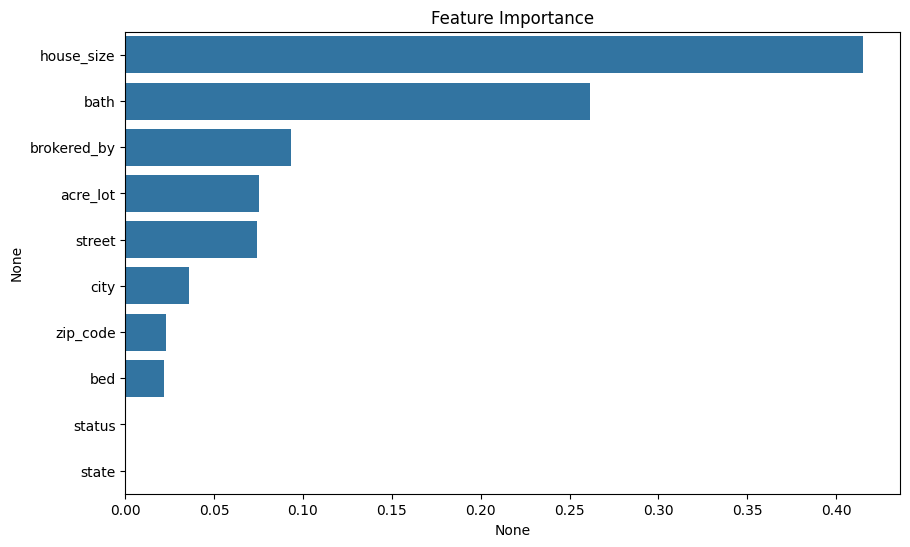

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.sort_values(ascending=False), y=feat_imp.sort_values(ascending=False).index)
plt.title("Feature Importance")
plt.show()


In [13]:
!pip install xgboost


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, r2_score


In [15]:
# 1. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# 2. XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# 3. Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)


In [17]:
models = {
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred,
    'Lasso': lasso_pred
}

print("{:<15} {:>10} {:>10}".format("Model", "R² Score", "MAE"))
print("-" * 35)

for name, preds in models.items():
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    print("{:<15} {:>10.4f} {:>10.2f}".format(name, r2, mae))


Model             R² Score        MAE
-----------------------------------
Random Forest       0.4978  547777.60
XGBoost            -0.0173  648115.81
Lasso               0.2068 1007187.38
